# LSTM for time series forecasting

## Predicting Google Stock Price

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import mean_squared_error


In [2]:
df=pd.read_csv("Google_Stock_Price_Train.csv")
print('Number of rows and columns:', df.shape)
print(df.head(5))


Number of rows and columns: (1258, 6)
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800


In [3]:
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [4]:
df.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


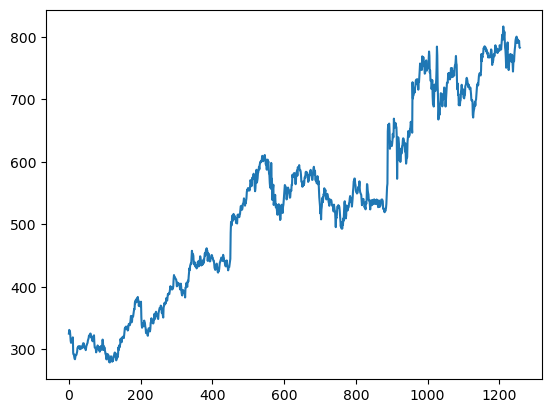

In [5]:
timeseries = df[["Open"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

In [6]:
# train-test split for time series
train_size = int(len(timeseries) * 0.80)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [7]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1002, 4, 1]) torch.Size([1002, 4, 1])
torch.Size([248, 4, 1]) torch.Size([248, 4, 1])


/var/folders/17/4285dbgn7mn02zyth407hz2h0000gn/T/ipykernel_27451/3189246061.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)


# Model 1

In [8]:
class my_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [9]:
model = my_LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 3000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 492.5304, test RMSE 740.7903
Epoch 100: train RMSE 239.6107, test RMSE 469.7788
Epoch 200: train RMSE 71.9078, test RMSE 220.3078
Epoch 300: train RMSE 24.3622, test RMSE 86.4164
Epoch 400: train RMSE 13.7354, test RMSE 50.2299
Epoch 500: train RMSE 10.9794, test RMSE 35.0027
Epoch 600: train RMSE 10.4750, test RMSE 26.9113
Epoch 700: train RMSE 9.4215, test RMSE 23.0456
Epoch 800: train RMSE 9.1353, test RMSE 20.0603
Epoch 900: train RMSE 8.6608, test RMSE 18.2412
Epoch 1000: train RMSE 8.8220, test RMSE 17.4735
Epoch 1100: train RMSE 9.5845, test RMSE 15.6426
Epoch 1200: train RMSE 8.6378, test RMSE 15.5872
Epoch 1300: train RMSE 8.2758, test RMSE 15.5450
Epoch 1400: train RMSE 8.5034, test RMSE 15.4744
Epoch 1500: train RMSE 11.5699, test RMSE 17.9070
Epoch 1600: train RMSE 8.4970, test RMSE 15.7422
Epoch 1700: train RMSE 8.7019, test RMSE 18.1669
Epoch 1800: train RMSE 10.0965, test RMSE 17.8460
Epoch 1900: train RMSE 9.8607, test RMSE 20.4662
Epoch 2000: train 

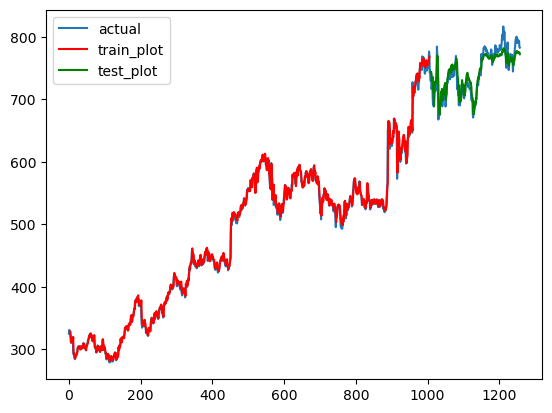

In [10]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

    

# plot
plt.plot(timeseries,label='actual')
plt.plot(train_plot, c='r', label='train_plot')
plt.plot(test_plot, c='g',label='test_plot')
plt.legend()

plt.show()

# Model 2

In [11]:
class my_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=30, num_layers=5, batch_first=True)
        self.linear = nn.Linear(30, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [12]:
model = my_LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 3000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 489.3883, test RMSE 737.5508
Epoch 100: train RMSE 189.4686, test RMSE 407.3646
Epoch 200: train RMSE 130.0672, test RMSE 274.0380
Epoch 300: train RMSE 130.0118, test RMSE 273.7715
Epoch 400: train RMSE 129.9565, test RMSE 273.8941
Epoch 500: train RMSE 129.9017, test RMSE 273.7409
Epoch 600: train RMSE 129.8469, test RMSE 273.7218
Epoch 700: train RMSE 129.7929, test RMSE 273.7899
Epoch 800: train RMSE 129.7392, test RMSE 273.6135
Epoch 900: train RMSE 129.6853, test RMSE 273.7026
Epoch 1000: train RMSE 129.6323, test RMSE 273.3239
Epoch 1100: train RMSE 129.5791, test RMSE 273.5233
Epoch 1200: train RMSE 129.5266, test RMSE 273.5688
Epoch 1300: train RMSE 129.4743, test RMSE 273.3663
Epoch 1400: train RMSE 129.4226, test RMSE 273.4210
Epoch 1500: train RMSE 129.3713, test RMSE 273.4122
Epoch 1600: train RMSE 129.3197, test RMSE 273.5192
Epoch 1700: train RMSE 129.2686, test RMSE 273.4633
Epoch 1800: train RMSE 129.2181, test RMSE 273.1216
Epoch 1900: train RMSE 1

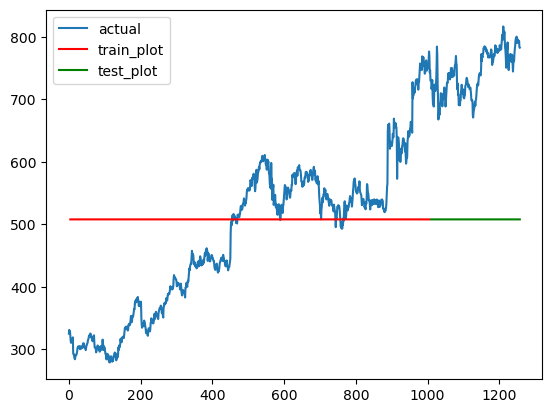

In [13]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

# plot
plt.plot(timeseries,label='actual')
plt.plot(train_plot, c='r', label='train_plot')
plt.plot(test_plot, c='g',label='test_plot')
plt.legend()

plt.show()

# Model 3

In [14]:
class my_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=70, num_layers=5, batch_first=True)
        self.linear = nn.Linear(70, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [15]:
model = my_LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 3000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 483.0682, test RMSE 731.0333
Epoch 100: train RMSE 129.2521, test RMSE 282.2025
Epoch 200: train RMSE 61.2840, test RMSE 139.7580
Epoch 300: train RMSE 60.8277, test RMSE 135.0250
Epoch 400: train RMSE 60.7649, test RMSE 134.4123
Epoch 500: train RMSE 60.9452, test RMSE 134.4639
Epoch 600: train RMSE 60.7231, test RMSE 134.5534
Epoch 700: train RMSE 60.6255, test RMSE 134.3912
Epoch 800: train RMSE 60.7212, test RMSE 134.7552
Epoch 900: train RMSE 60.8858, test RMSE 135.0264
Epoch 1000: train RMSE 60.8940, test RMSE 134.4495
Epoch 1100: train RMSE 60.8156, test RMSE 134.8755
Epoch 1200: train RMSE 60.9820, test RMSE 134.5398
Epoch 1300: train RMSE 61.1616, test RMSE 134.9406
Epoch 1400: train RMSE 60.7768, test RMSE 134.8744
Epoch 1500: train RMSE 24.7760, test RMSE 97.3765
Epoch 1600: train RMSE 10.0019, test RMSE 30.3969
Epoch 1700: train RMSE 11.4686, test RMSE 23.3905
Epoch 1800: train RMSE 8.6305, test RMSE 23.2773
Epoch 1900: train RMSE 10.3153, test RMSE 25.8

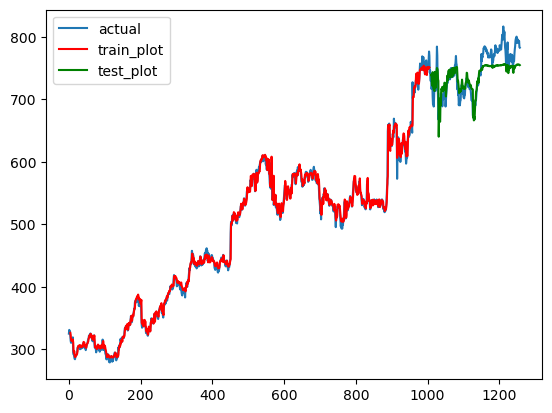

In [16]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


# plot
plt.plot(timeseries,label='actual')
plt.plot(train_plot, c='r', label='train_plot')
plt.plot(test_plot, c='g',label='test_plot')
plt.legend()

plt.show()


## Model 1 gives the best results using it to predict the prices of latest year 2016

### Reusing the model 1

Epoch 0: train RMSE 491.2282, test RMSE 739.4465
Epoch 100: train RMSE 202.0982, test RMSE 424.0663
Epoch 200: train RMSE 53.2028, test RMSE 167.8855
Epoch 300: train RMSE 27.3787, test RMSE 87.2768
Epoch 400: train RMSE 19.3648, test RMSE 71.4606
Epoch 500: train RMSE 12.9113, test RMSE 45.0936
Epoch 600: train RMSE 10.0560, test RMSE 29.3095
Epoch 700: train RMSE 9.1480, test RMSE 23.9741
Epoch 800: train RMSE 8.6071, test RMSE 19.2216
Epoch 900: train RMSE 8.3939, test RMSE 17.7809
Epoch 1000: train RMSE 9.2245, test RMSE 20.4738
Epoch 1100: train RMSE 8.4137, test RMSE 15.0926
Epoch 1200: train RMSE 10.1804, test RMSE 23.7374
Epoch 1300: train RMSE 9.4071, test RMSE 17.0664
Epoch 1400: train RMSE 8.4168, test RMSE 13.5832
Epoch 1500: train RMSE 9.0827, test RMSE 16.0862
Epoch 1600: train RMSE 8.2908, test RMSE 15.5802
Epoch 1700: train RMSE 9.2370, test RMSE 14.7940
Epoch 1800: train RMSE 8.3950, test RMSE 15.1543
Epoch 1900: train RMSE 9.4842, test RMSE 14.2211
Epoch 2000: train R

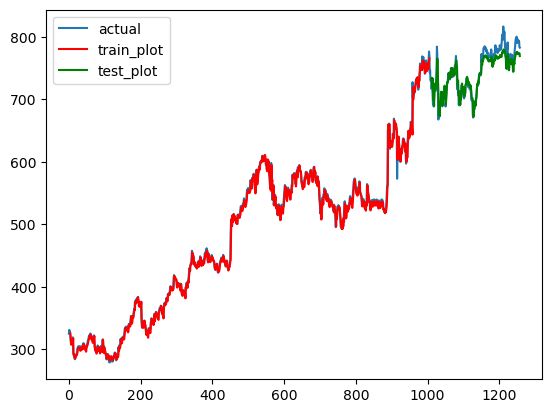

In [18]:
class my_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
model = my_LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 3000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

# plot
plt.plot(timeseries,label='actual')
plt.plot(train_plot, c='r', label='train_plot')
plt.plot(test_plot, c='g',label='test_plot')
plt.legend()

plt.show()

In [19]:
year_2016 = df[df['Date'].str.contains('2016')]
dataset_train = year_2016.iloc[:, 1:2].values  # Extracting values from DataFrame  # Reshaping the extracted values
input_tensor = torch.tensor(dataset_train, dtype=torch.float32).unsqueeze(1)


RMSE for last year: 20.922126040692433


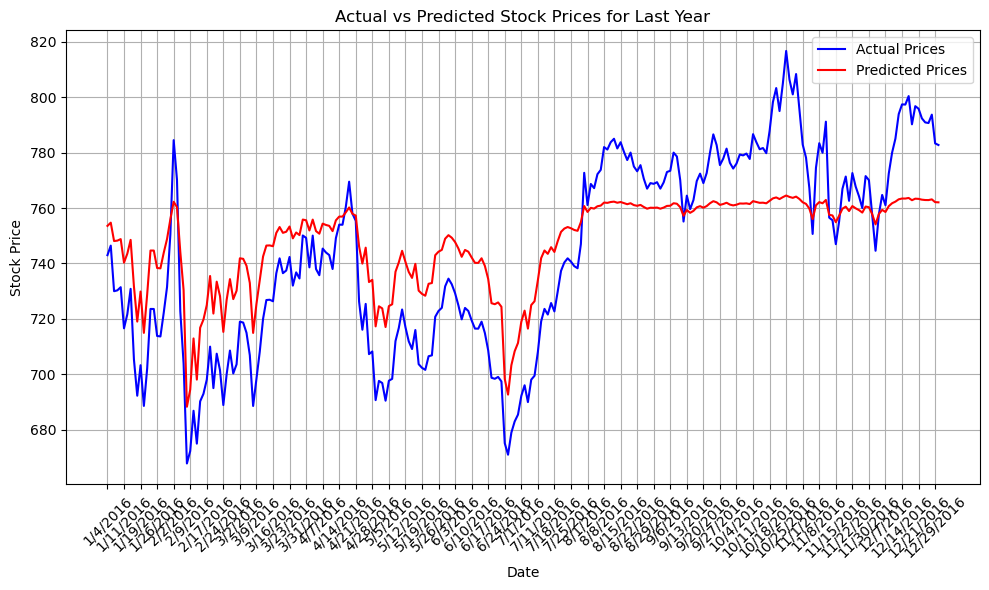

In [20]:
#predicting the stock price for  2016
model.eval()
with torch.no_grad():
    y_pred_last_year = model(input_tensor)

# Assuming df contains the actual stock prices
actual_prices_last_year = dataset_train
y_pred_last_year_np = y_pred_last_year.squeeze().numpy()

rmse_last_year = np.sqrt(mean_squared_error(actual_prices_last_year, y_pred_last_year_np))
print("RMSE for last year:", rmse_last_year)

dates_last_year = year_2016['Date']
plt.figure(figsize=(10, 6))
plt.plot(dates_last_year, actual_prices_last_year, label='Actual Prices', color='blue')
plt.plot(dates_last_year, y_pred_last_year_np, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices for Last Year')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(dates_last_year[::5], rotation=45)  # Show every 5th date and rotate labels
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()